# TP1 - Neural Networks from scratch

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework).

Following code allows you to mount your drive in the Colab Virtual Machine in order to get access to the data (skipped if run locally)

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'DEEPL_TP_1'
  %cd /content/gdrive/MyDrive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/MyDrive/DEEPL_TP_1


## Part 0. A simple Multi-Layer Perceptron (MLP) implementation

As always some useful imports:

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import scipy.ndimage as ndimage
import scipy.optimize as optimize

import os

try:
    # tqdm is a very useful library to monitor the progression of your loops
    # (not necessary but handy)
    from tqdm.notebook import tqdm
except ImportError:
    pass

We will consider a Neural Network as a modular architecture, all layer and loss being a `Module`. We define the `Linear`, `ReLU` layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the meaned square error function, `MSE`.

**Q1.a.** Read carefully the code below, and summarize in a few sentences what is the structure and the purpose of each class.

**Your answer**

# La classe Module est la base de toutes les autres : elle définit la structure commune d'un module de réseau neuronal, avec les méthodes forward (calcul direct) et backward (propagation du gradient). Toutes les autres classes héritent de cette logique.

# MSE représente la fonction de perte “Mean Squared Error”. Elle compare les prédictions au vrai label et calcule l'erreur moyenne. Son backward fournit le gradient du MSE, point de départ de la rétropropagation.

# Linear modélise une couche entièrement connectée : forward applique la transformation linéaire xW^T + b, backward calcule les gradients par rapport aux poids, biais et entrées, et gradientStep met à jour les paramètres. C'est le cœur des calculs dans un réseau.

# ReLU ajoute la touche non-linéaire indispensable : forward remplace les valeurs négatives par 0, backward ne laisse passer le gradient que pour les activations positives — bref, un filtre à “bonnes vibes”.

# Enfin, SimpleMLP assemble tout ça : deux couches linéaires séparées par une ReLU. forward fait circuler les données de l'entrée à la sortie, backward fait le chemin inverse, et gradientStep ajuste les paramètres.

In [3]:
class Module(object):
    def __init__(self):
        self.gradInput = None
        self.output = None

    def forward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError

    def backward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError


class MSE(Module):
    """
    This implementation of the mean squared loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (batch_size)
    """
    def __init__(self, num_classes=10):
        super(MSE, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1

        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        self.output = np.sum((target-x)**2, axis=1)
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = -2*(target - x) / x.shape[0]
        return self.gradInput


class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        std = math.sqrt(2/in_features) # He init because we have ReLU.
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr):
        self.weight = self.weight - lr*self.gradWeight
        self.bias = self.bias - lr*self.gradBias


class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()

    def forward(self, x):
        self.output = x.clip(0)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = (x>0) * gradOutput
        return self.gradInput


class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

## Part Ia. Training a neural network

To train a network, we will need data. Download the Mini-MNIST data (~4Mo). It consists of 28×28 images (loaded as vectors of size 784) and the associated label for training and test sets.

n_train=9000, n_val=1000, n_test=2000
5


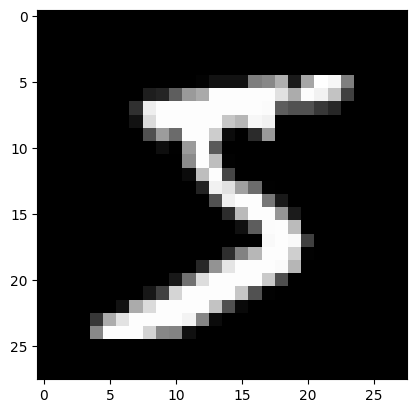

In [4]:
data = np.load("mini_mnist.npz")

train_data = data["train_data"]
train_labels = data["train_labels"]
test_data = data["test_data"]
test_labels = data["test_labels"]

N_val = int(0.1 * len(train_data))
val_data = train_data[-N_val:]
val_labels = train_labels[-N_val:]

N_train = len(train_data) - N_val
train_data = train_data[:N_train]
train_labels = train_labels[:N_train]

N_test = test_data.shape[0]

print(f'n_train={N_train}, n_val={N_val}, n_test={N_test}')

# Check that data makes sense
plt.figure()
plt.imshow(train_data[0, :].reshape(28,28))
print(train_labels[0])
plt.show()

**Q1.b.** Read and understand the code above and explain in a few words why we need to split data in {train, val, test}

**Your answer**

#On sépare les données en train, validation et test pour bien évaluer la performance du modèle.
#•	Le train set sert à entraîner le modèle, c'est là qu'il apprend les motifs des données.
#•	Le validation set sert à ajuster les hyperparamètres (comme le taux d'apprentissage ou la taille du réseau) sans biaiser le modèle.
#•	Le test set est gardé de côté jusqu'à la fin pour mesurer la performance réelle du modèle sur des données totalement nouvelles.

#En résumé : on entraîne sur le train, on ajuste sur le val, et on juge sur le test

**Q2.** Plot a grid of 5x5 images showing the first 25 samples of the dataset with associated labels

*Help*:
- execute `?function` to get the doc of a function
- instanciation of a figure can be done with `fig, axes = plt.subplot(n_row, n_col, figsize=(width, height))`, where `fig` is a Figure and `axes` is a 2D array of Axes
- access an axis element through `axes[i][j]`
- given an axis element `ax`, plot image with `ax.imshow` and add a title with `ax.set_title`

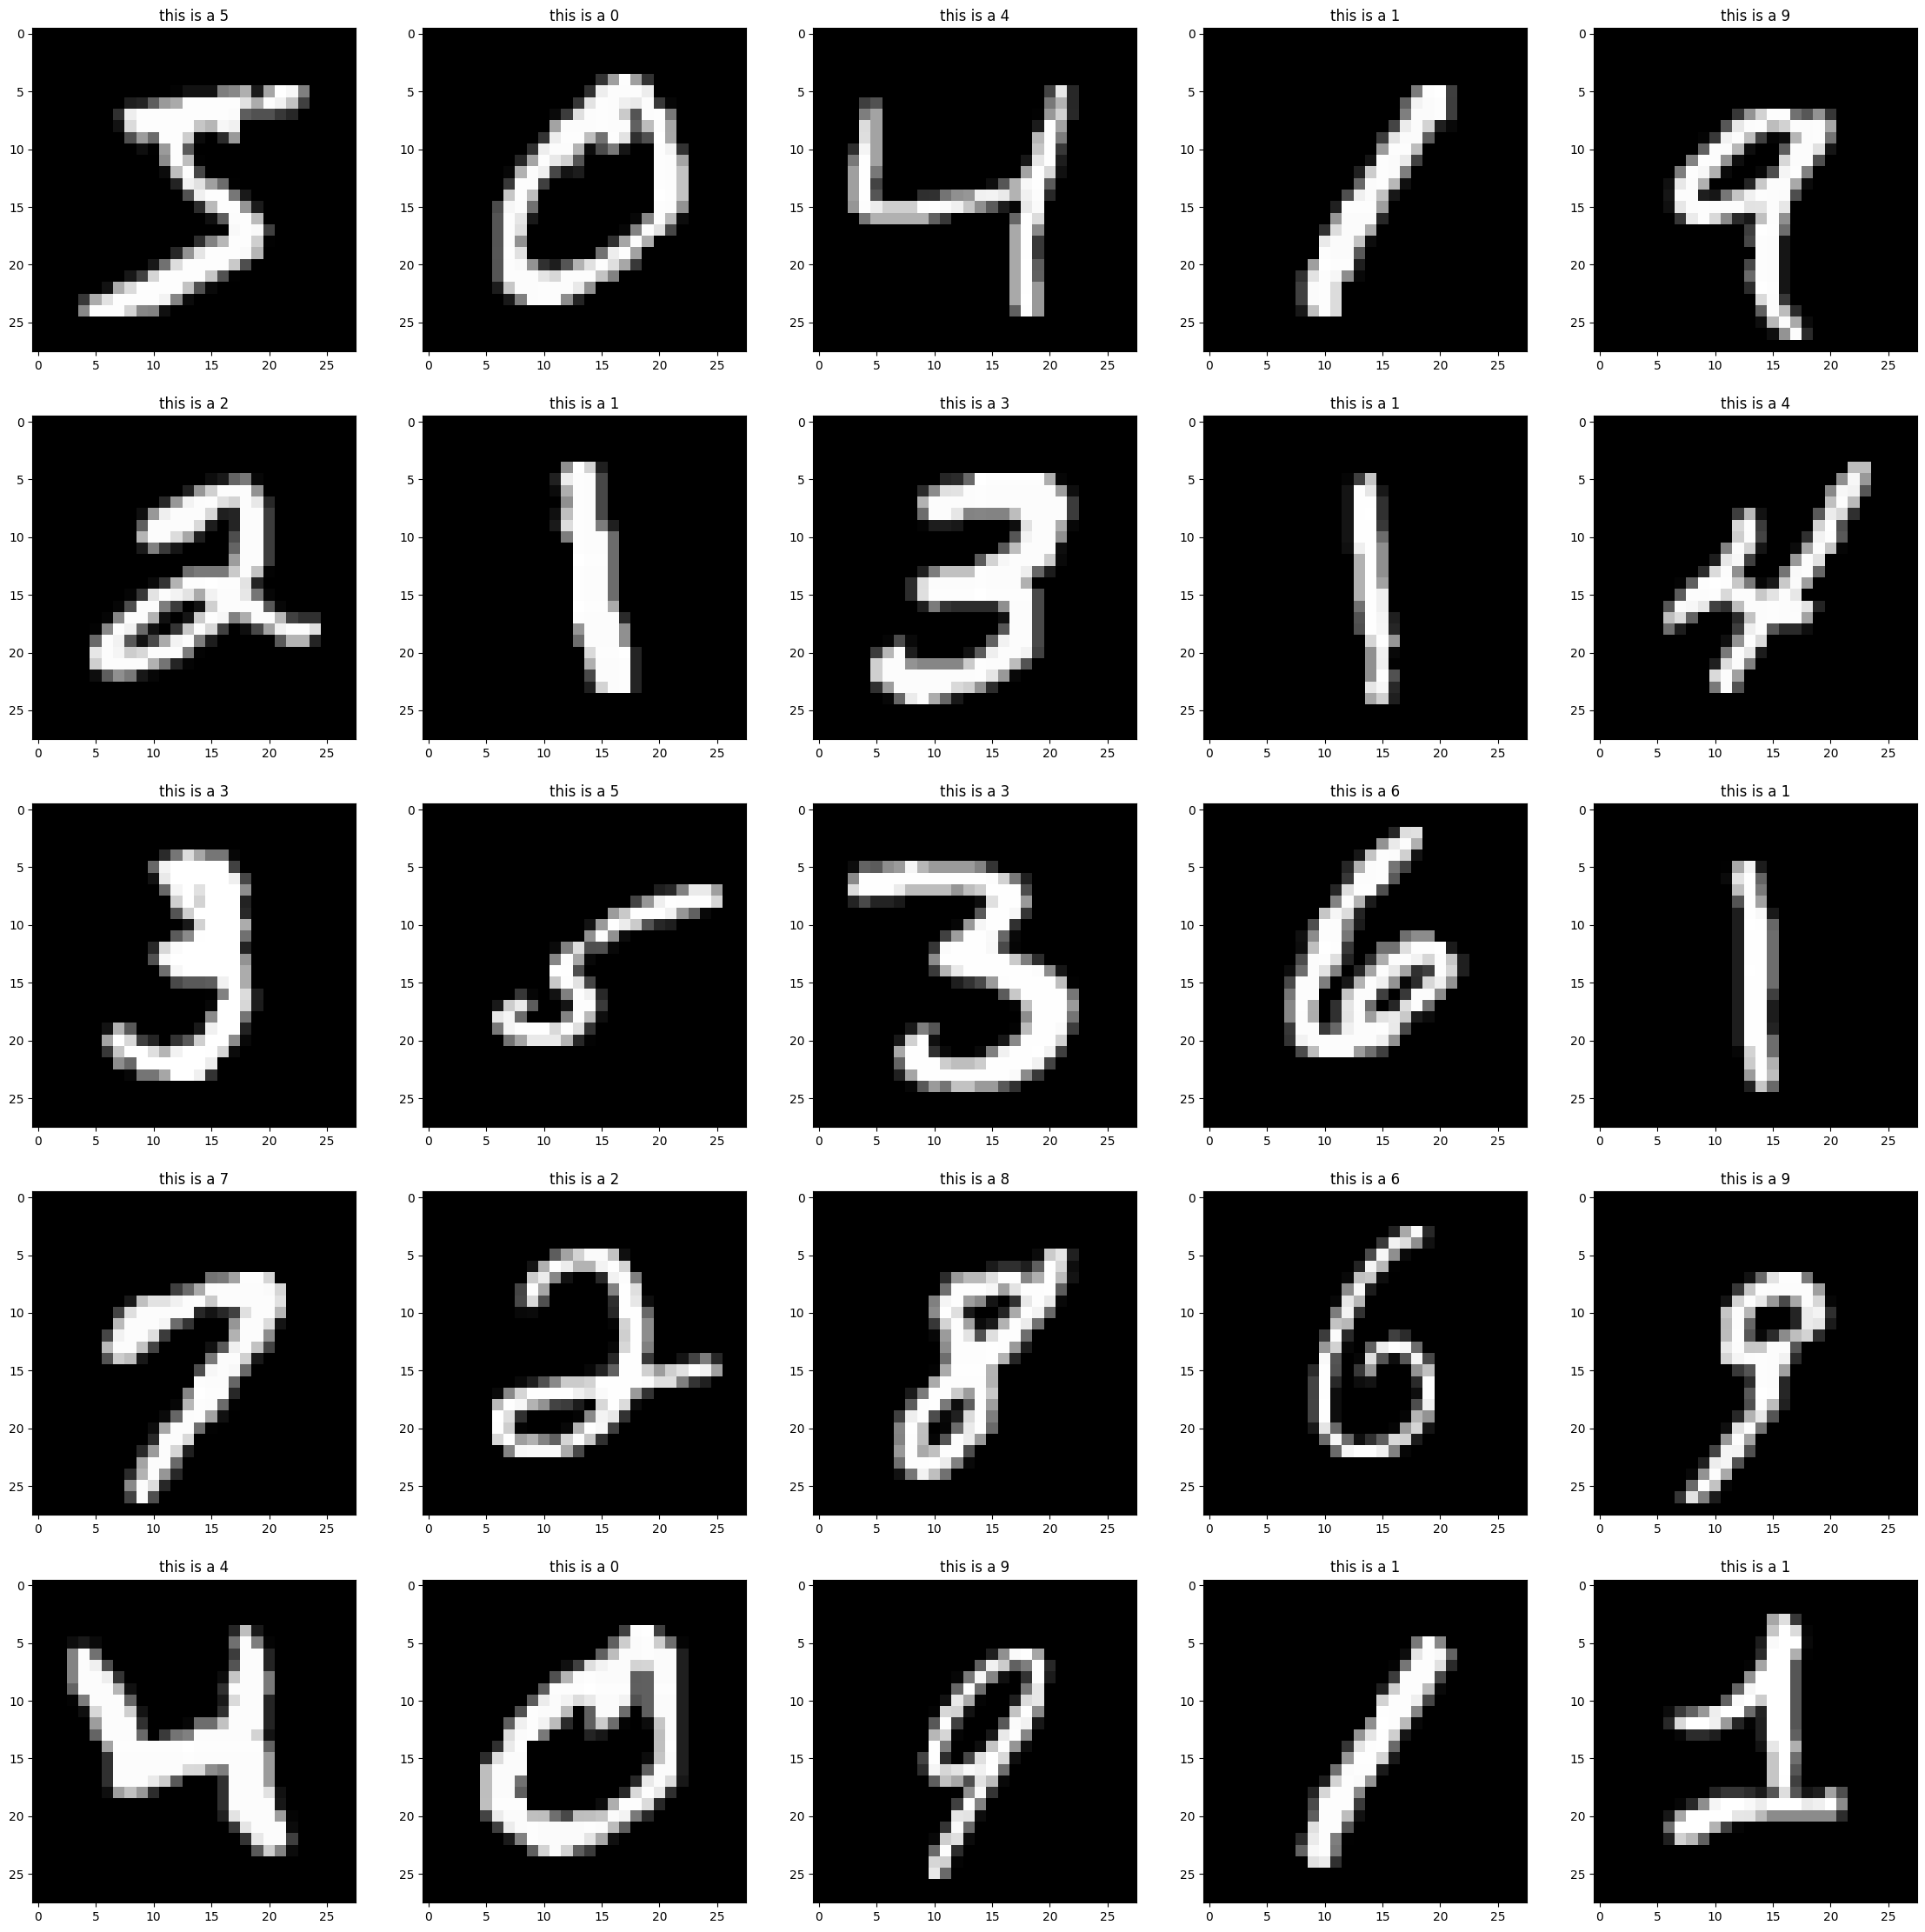

In [5]:
# Your code
grid_size = 5
fig, axes = plt.subplots(grid_size, grid_size, figsize=(28, 28))    # subplots avec un s
for i in range(grid_size):
  for j in range(grid_size):
    axes[i][j].imshow(train_data[grid_size*i+j, :].reshape(28,28))
    axes[i][j].set_title(f"this is a {train_labels[grid_size*i + j]}")
plt.show()


**Q3.a.** Write a function `train_iter(model, loss, batch_data, batch_labels, lr)` that performs one iteration of gradient descent given `model` and `loss` (subclasses of `Module`) on a batch `(batch_data, batch_labels)` with a learning rate `lr`, and returns the training loss value.

*Help:*
1. Make the predictions (`model.forward`)
2. Compute the loss between the predictions and the labels (`loss.forward`)
3. Compute its gradient wrt the predictions and the labels (`loss.backward`)
4. Backpropagate the gradient into the model (`model.backward`)
5. Perform gradient descent (`model.gradientStep`)




In [6]:
# Your code
def train_iter(model, loss, batch_data, batch_labels, lr):
  predictions = model.forward(batch_data)
  loss_value = loss.forward(predictions, batch_labels)
  loss_grad = loss.backward(predictions, batch_labels)
  model.backward(batch_data, loss_grad)
  model.gradientStep(lr)
  return loss_value


**Q3.b.** Test your function. Write a simple loop that trains for 1 epoch a `SimpleMLP` using `MSE` loss on `train_data` with a learning rate of `1e-2` and batches of size `16`. You will print the loss every 10 iterations. To avoid overfitting, the training data should be shuffled before entering any new epoch.

*Note:* An **iteration** consists in running one batch of samples through the model; an **epoch** consists in running multiple iterations so that to process all the samples once.

*Help:* `np.random.shuffle` shuffles the content of an array inplace

In [7]:
lr = 1e-2
batch_size = 16

# Your code
N = train_data.shape[0] // batch_size # iterations per epoch
model = SimpleMLP()
loss = MSE()

for epoch in range(1):
  # shuffle without loosing the initial order, np.random.shuffle made my code fail
  indices = np.random.permutation(len(train_data))
  data = train_data[indices]
  labels = train_labels[indices]
  for i in range(N):
    batch_data = data[i*batch_size : (i+1)*batch_size]
    batch_labels = labels[i*batch_size : (i+1)*batch_size]
    loss_value = train_iter(model, loss, batch_data, batch_labels, lr)
    if i % 10 == 0:
        print(f"iteration {i}, loss {loss_value}")


iteration 0, loss 2.325543442996353
iteration 10, loss 1.077012479125688
iteration 20, loss 0.9964980443800416
iteration 30, loss 0.7696316873067974
iteration 40, loss 0.9646091975213188
iteration 50, loss 0.8049797994203166
iteration 60, loss 0.8662293219009065
iteration 70, loss 0.7454610972099134
iteration 80, loss 0.6338630349516312
iteration 90, loss 0.7164392013556868
iteration 100, loss 0.5932966499215891
iteration 110, loss 0.7752442921499307
iteration 120, loss 0.7048725427517265
iteration 130, loss 0.6817290299735935
iteration 140, loss 0.5011224303349955
iteration 150, loss 0.551629212009656
iteration 160, loss 0.6054306193775058
iteration 170, loss 0.545260156107016
iteration 180, loss 0.4989924906372596
iteration 190, loss 0.6555262147196204
iteration 200, loss 0.5841996427506846
iteration 210, loss 0.5800990800520642
iteration 220, loss 0.5784714925994225
iteration 230, loss 0.6466901397531273
iteration 240, loss 0.7068866634468518
iteration 250, loss 0.46546003261807
ite

**Q4.a.** Write a function `evaluate(model, loss, data, labels)` that returns a couple `(loss, accuracy)` corresponding to the loss and accuracy computed on some `data`.

*NB:* `for` loops are so slow, avoid them as much as possible!




In [8]:
# Your code
def evaluate(model, loss, data, labels):
  predictions = model.forward(data)
  loss_value = loss.forward(predictions, labels)
  accuracy = np.mean(np.argmax(predictions, axis=1) == labels)
  return loss_value, accuracy

**Q4.b.** Use your function to evaluate the model trained in **Q3.b.** on the validation data.


In [9]:
# Your code
loss_value, accuracy = evaluate(model, loss, val_data, val_labels)
print(f"loss {loss_value}, accuracy {accuracy}")

loss 0.37796163887339523, accuracy 0.863




**Q4.c.** Check visually the quality of the results by plotting 25 validation examples and their predictions.

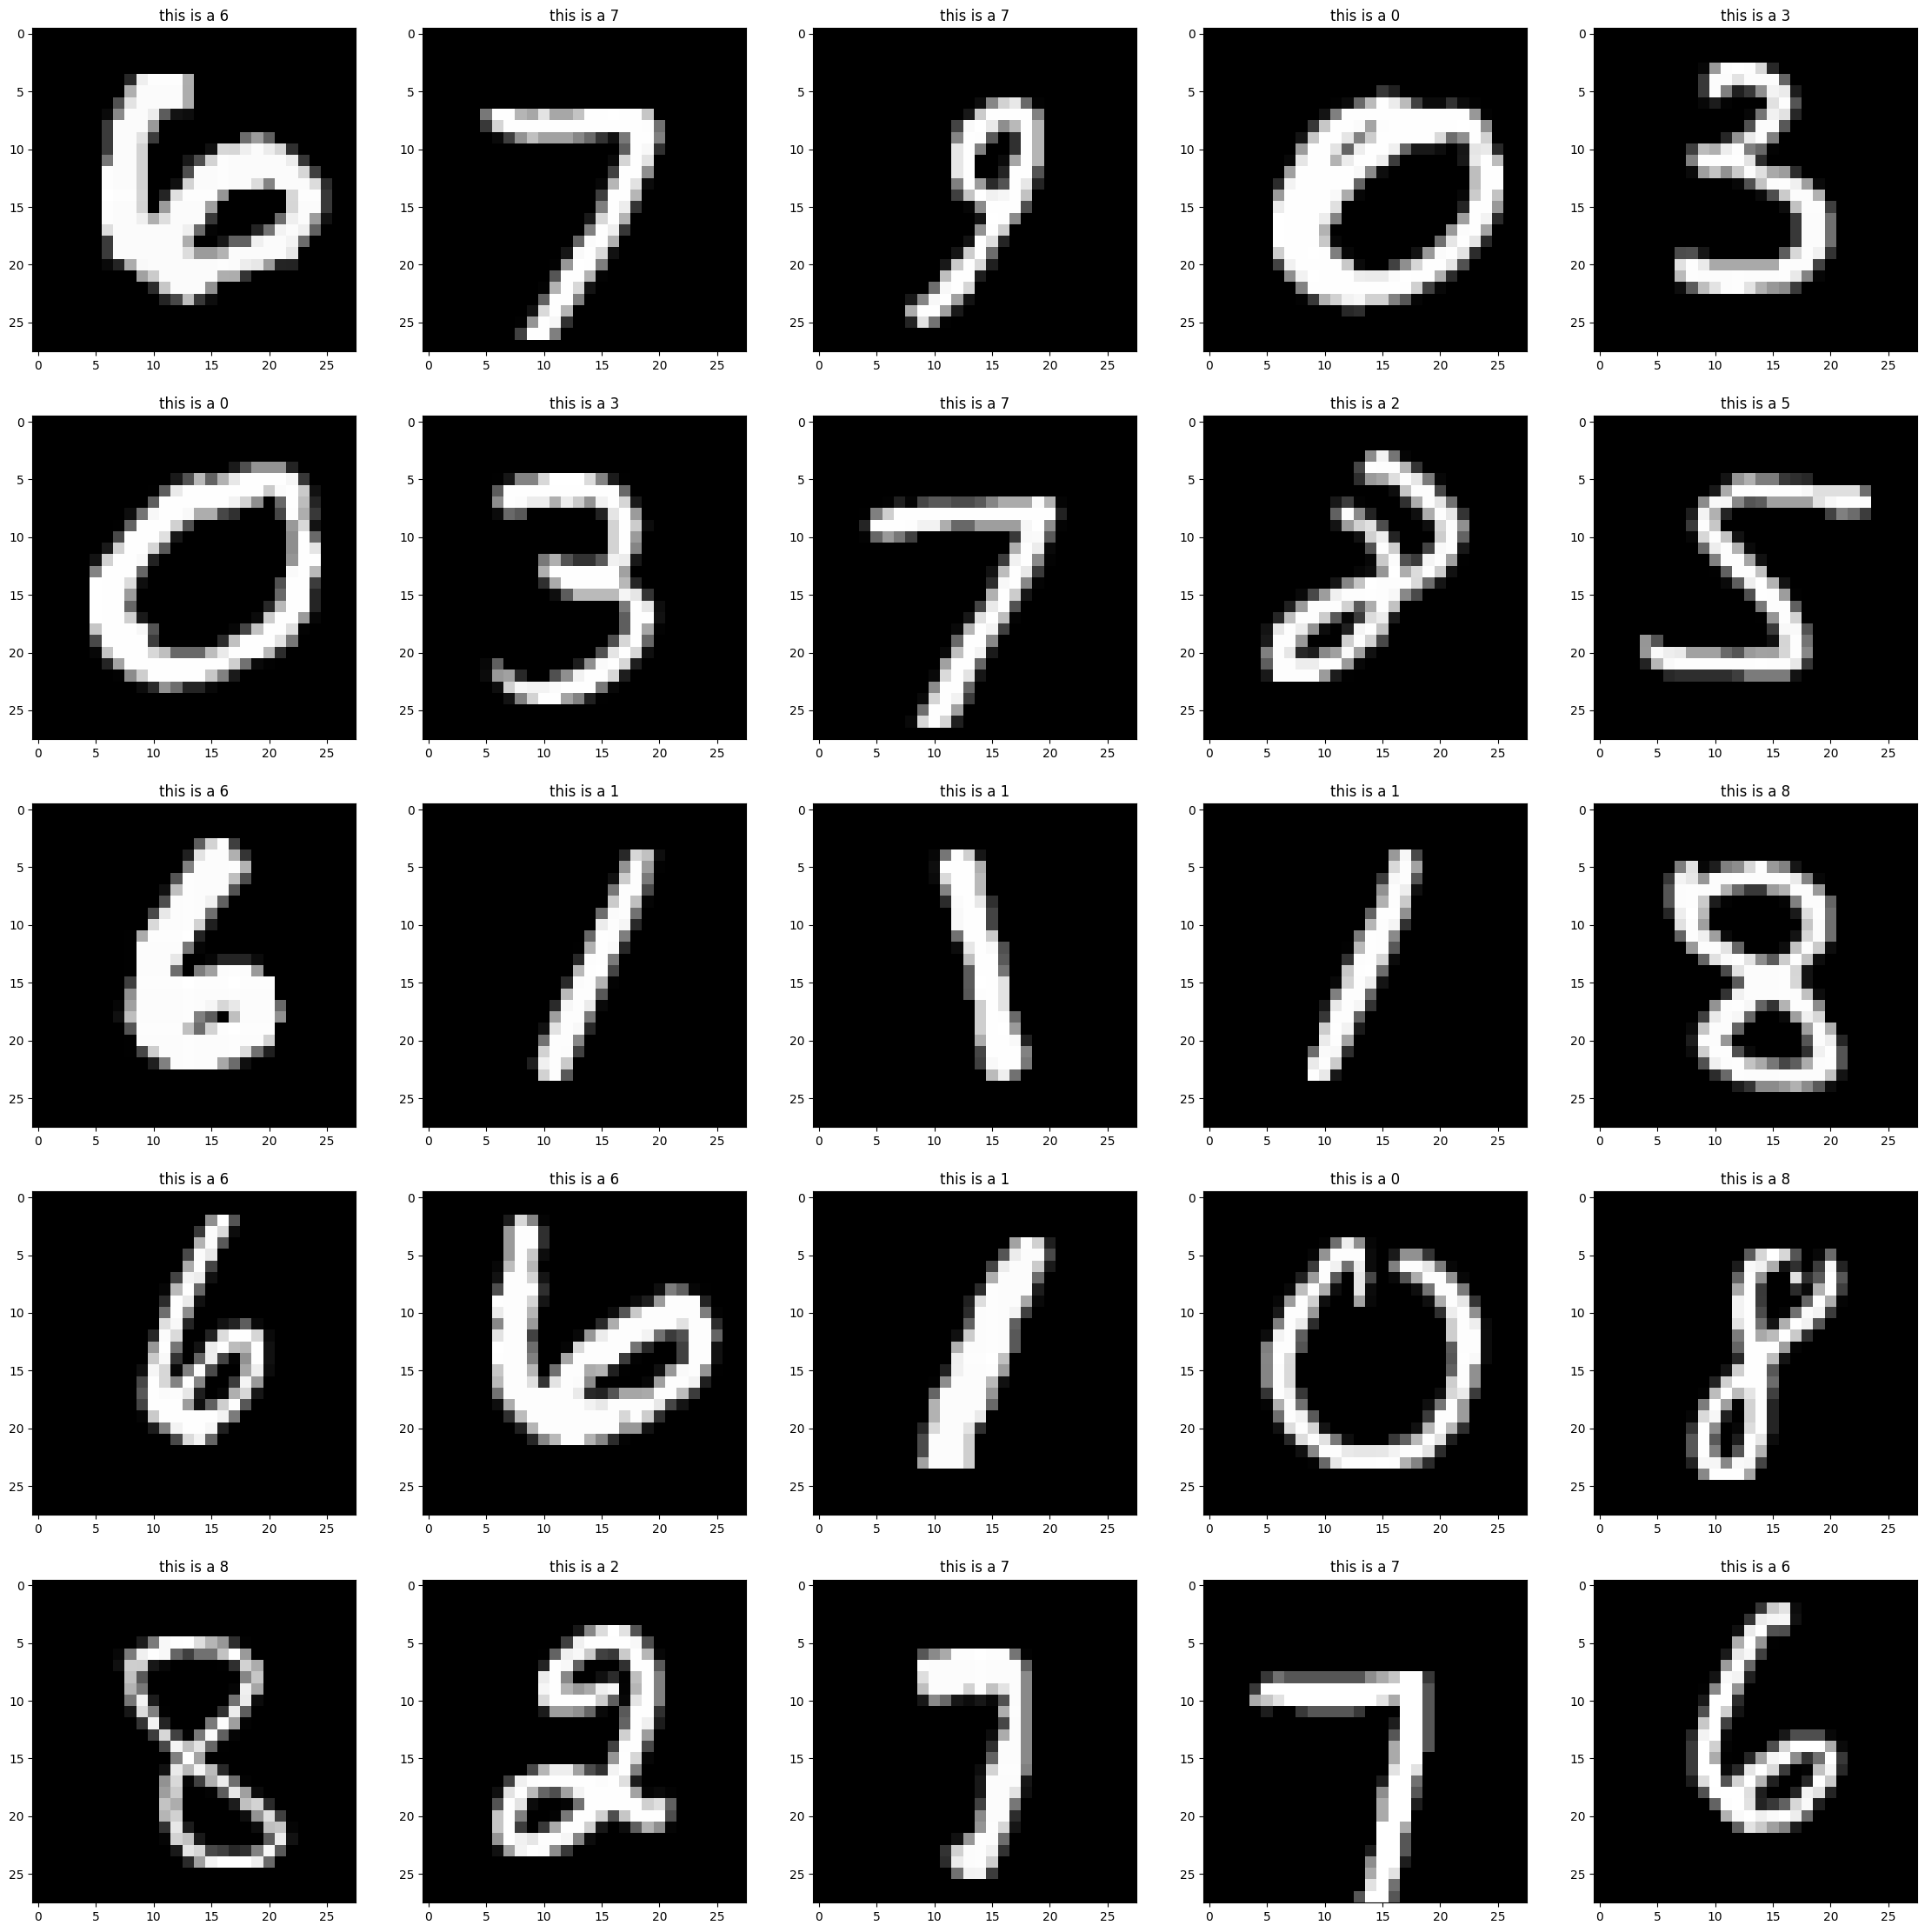

In [10]:
# Your code
grid_size = 5
fig, axes = plt.subplots(grid_size, grid_size, figsize=(28, 28))    # subplots avec un s
predictions = model.forward(val_data)
predictions = np.argmax(predictions, axis=1)
for i in range(grid_size):
  for j in range(grid_size):
    axes[i][j].imshow(val_data[grid_size*i+j, :].reshape(28,28))
    axes[i][j].set_title(f"this is a {predictions[grid_size*i + j]}")
plt.show()

**Q4.d.** Make a failure case analysis on the full validation data using (i) a bar plot showing the percentage of error for each class and (ii) the prediction distribution over the classes for some failure cases. Comment briefly.

*Help:*
- `plt.bar` can be used to do a barplot
- `np.unique` is useful to compute unique elements in an array as well as respective count

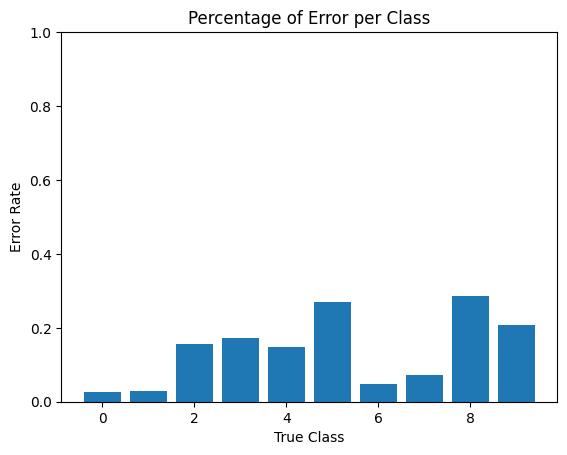

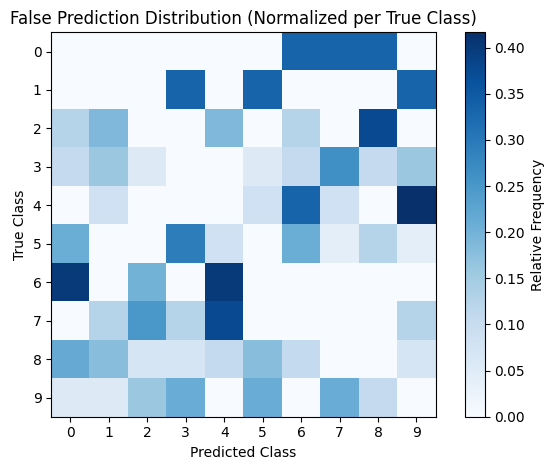

'\nOverall, these plots reveal not just how much the model fails, but where and why.\nIf one or two classes dominate the error, it might indicate imbalance in the dataset or insufficient representational power in the model.\nTo improve, we could try data augmentation, a deeper network, or better initialization.\n'

In [11]:
def present():
    num_classes = 10
    predictions = np.argmax(model.forward(val_data), axis=1)

    number_in_class = np.zeros(num_classes)
    errors_in_class = np.zeros(num_classes)
    false_pred_dist = np.zeros((num_classes, num_classes))

    for i in range(len(val_labels)):
        true = val_labels[i]
        pred = predictions[i]
        number_in_class[true] += 1
        if pred != true:
            errors_in_class[true] += 1
            false_pred_dist[true, pred] += 1

    percentage_error = errors_in_class / number_in_class

    for i in range(num_classes):
        if errors_in_class[i] > 0:
            false_pred_dist[i] /= errors_in_class[i]

    plt.figure()
    plt.bar(range(num_classes), percentage_error)
    plt.title("Percentage of Error per Class")
    plt.xlabel("True Class")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.imshow(false_pred_dist, cmap='Blues')
    plt.title("False Prediction Distribution (Normalized per True Class)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.xticks(range(num_classes))
    plt.yticks(range(num_classes))
    plt.colorbar(label="Relative Frequency")
    plt.tight_layout()
    plt.show()

present()
"""
Overall, these plots reveal not just how much the model fails, but where and why.
If one or two classes dominate the error, it might indicate imbalance in the dataset or insufficient representational power in the model.
To improve, we could try data augmentation, a deeper network, or better initialization.
"""

## Part Ib. Training a neural network

**Q5.a.** Write a `train_epoch(model, loss, data, labels, val_data, val_labels, lr, batch_size)` function that trains a model for a whole epoch and returns train and val losses as well as accuracies on validation every 10 iterations (do not print anything during trainin this time). Test it to train a `SimpleMLP` from scratch for 2 epochs with the same parameters as in question **3.b.**

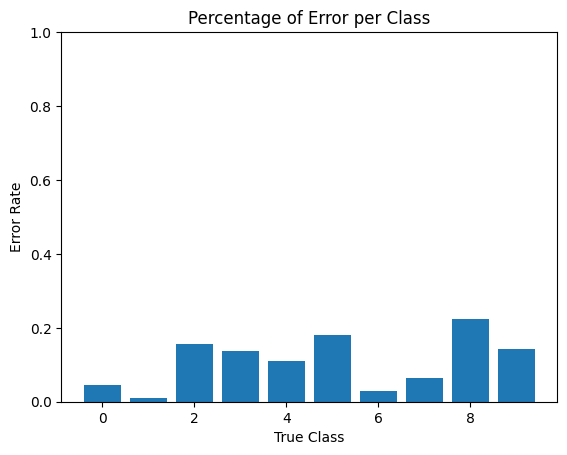

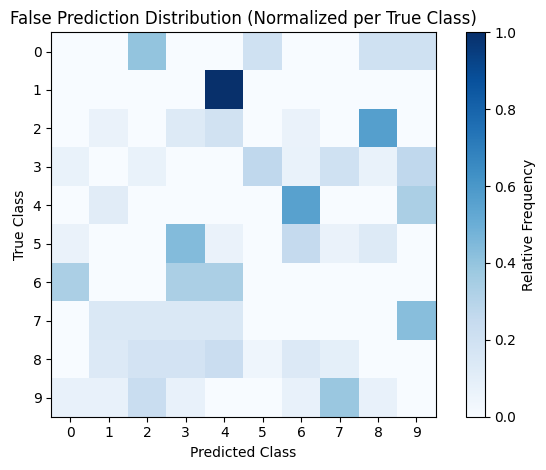

In [12]:
# Your code
def train_epoch(model, loss, data, labels, val_data, val_labels, lr, batch_size):
    Result = []
    N = data.shape[0] // batch_size
    indices = np.random.permutation(len(data))
    data = data[indices]
    labels = labels[indices]

    for i in range(N):
        batch_data = data[i*batch_size : (i+1)*batch_size]
        batch_labels = labels[i*batch_size : (i+1)*batch_size]
        train_iter(model, loss, batch_data, batch_labels, lr)
        if i % 10 == 0:
            loss_value, accuracy = evaluate(model, loss, data, labels)
            val_loss, val_accuracy = evaluate(model, loss, val_data, val_labels)
            Result.append([loss_value, val_loss, val_accuracy])

    return Result

lr = 1e-2
batch_size = 16
model = SimpleMLP()
loss = MSE()
res = []
epochs = 2
for i in range(epochs):
  res += train_epoch(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size)

present()

**Q5.b.** Plot train+val losses as well as the accuracy on the validation as a function of the number of iterations. Choose nice colors and add legends to ease the reading.

*Help:* you can simply use `plt.plot`

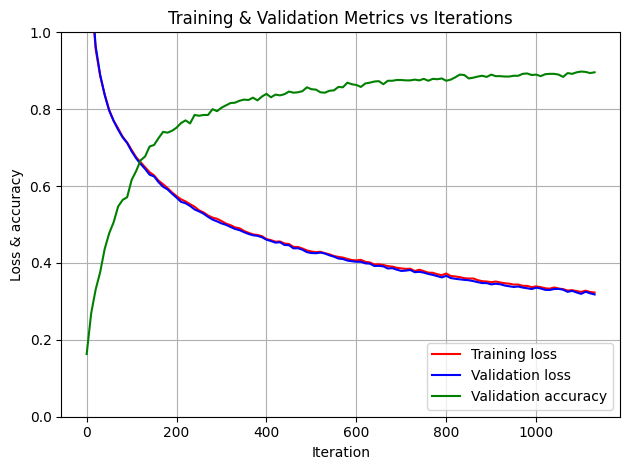

In [13]:
def plot_loss(res):
  N = len(res)
  iters = np.arange(0, 10*N, 10)

  loss_value = np.array([r[0] for r in res])
  val_loss   = np.array([r[1] for r in res])
  val_acc    = np.array([r[2] for r in res])

  l1, = plt.plot(iters, loss_value, 'r', label='Training loss')
  l2, = plt.plot(iters, val_loss, 'b', label='Validation loss')
  l3, = plt.plot(iters, val_acc, 'g-', label='Validation accuracy')
  plt.xlabel("Iteration")
  plt.ylabel("Loss & accuracy", color='k')
  plt.ylim(0, 1)

  lines = [l1, l2, l3]
  labels = [l.get_label() for l in lines]
  plt.legend(lines, labels, loc='lower right')

  plt.title("Training & Validation Metrics vs Iterations")
  plt.tight_layout()
  plt.grid()
  plt.show()
plot_loss(res)

**Q6.a.** Based on the previous questions, design a function

<center><pre>train(model, loss, train_data, train_labels, val_data, val_labels, ...)</pre></center>

that performs a full training of the input `model` on the training data. Choose the arguments of your function (for instance, `batch_size`, `lr`, `epochs`, etc) according to what seems relevant to you. This function should plot at the end the evolution of train / val losses and accuracies.

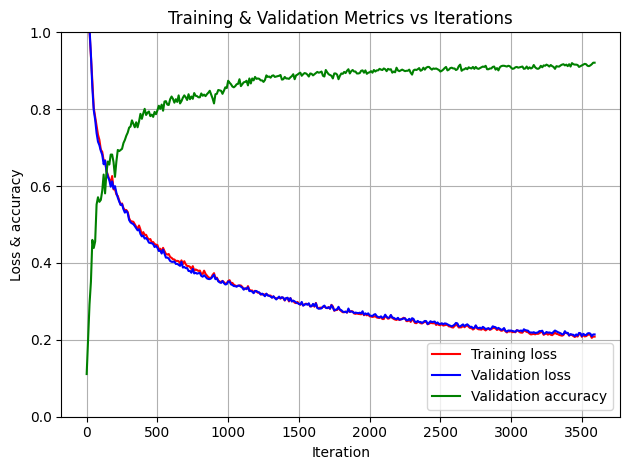

In [14]:
# Your code
def train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs):
  res = []
  for epoch in range(epochs):
    res += train_epoch(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size)
  plot_loss(res)

model = SimpleMLP()
loss = MSE()
lr = 10**(-2)
batch_size = 5
epochs = 2
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)

**Q6.b.** Use your function to train a model with a good accuracy (decide for a epoch, learning rate, batch size...)

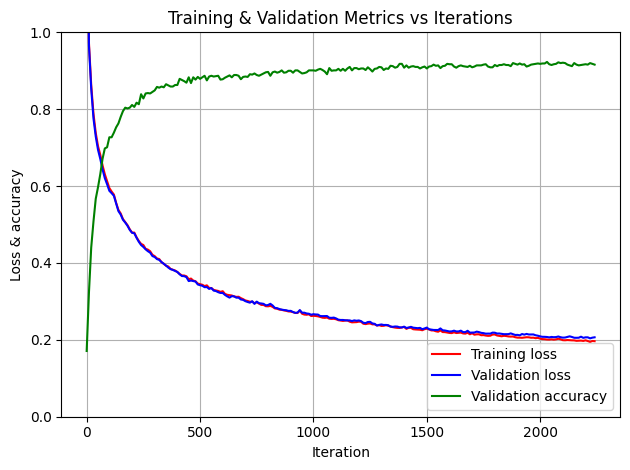

(np.float64(0.20364164306547883), np.float64(0.922))


In [15]:
# Your code
model = SimpleMLP()
loss = MSE()
lr = 0.015
batch_size = 20
epochs = 5
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)
print(evaluate(model, loss, val_data, val_labels))
# on obtien ici une accuracy de 0.929 !

## Part II. Overfitting

**Q7.** What's the number of parameters in the network `SimpleMLP` used in the first section?

**Your answer:** ...

#On passe d'une couche à 784 perceptrons à une couche cachée de 64 perceptrons à une couche de sortie à 10 perceptrons. On a donc 784 x 64 + 64 x 10 poids et 64 + 10 biais. Ce qui fait au total 50 890 paramètres.


**Q8.a.** Rewrite the definition of `SimpleMLP` to allow changing the dimension of the hidden layer. Test it by training 1 epoch with 128 hidden features and plotting its performances.

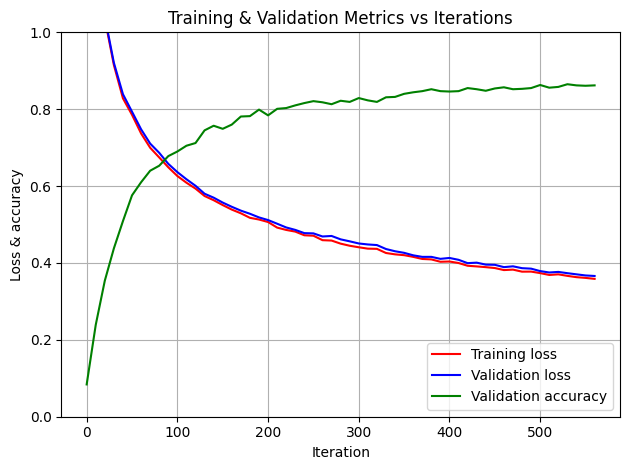

In [16]:
# Your code
class MLP(Module):
    """
    This class is an example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, in_hidden_layer = 128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(in_dimension, in_hidden_layer)
        self.relu1 = ReLU()
        self.fc2 = Linear(in_hidden_layer, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

model = MLP()
loss = MSE()
lr = 10**(-2)
batch_size = 16
epochs = 1
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)

**Q8.b.** Define a class `DoubleMLP` with three `Linear` layers and parameters to change their dimensions. Test it by training 1 epoch with [64, 32] hidden features and plotting its performances. Does it look better than `SimpleMLP`so far?

# Non, DoubleMLP ne performe pas mieux que SimpleMLP. Cependant en ajoutant des epochs on sent que l'on va pouvoir ameliorer le modele vu qu'il atteint son plateau plus doucement.

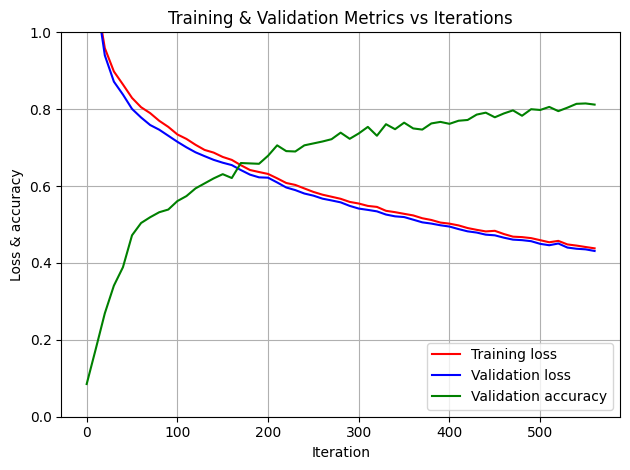

In [17]:
# Your code
class DoubleMLP(Module):
    """
    This class is an example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, layer_1 = 64, layer_2 = 32, num_classes=10):
        super(DoubleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, layer_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(layer_1, layer_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(layer_2, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)

        return gradient

    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

model = DoubleMLP()
loss = MSE()
lr = 10**(-2)
batch_size = 16
epochs = 1
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)

**Q8.c.** Define a class `DeepMLP` with a **list** parameter `hidden_features` that allows to vary the number of intermediate linear layers, and their dimensions:

- `DeepMLP([64])` should be equivalent to `SimpleMLP()`;
- `DeepMLP([64, 64, 64])` should be a MLP with four linear layers...

Test it by training 1 epoch with [64, 64, 32] hidden features and plotting its performances.

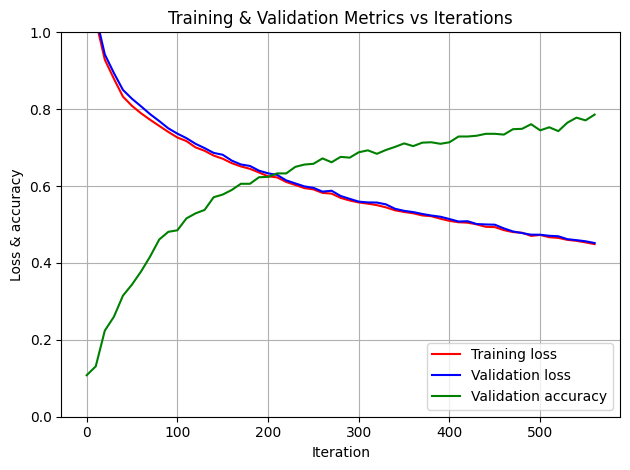

In [24]:
# Your code
class DeepMLP(Module):
    """
    Réseau multi-couches avec une non-linéarité entre chaque couche cachée.
    """
    def __init__(self, hidden_features, non_linearity=ReLU, linear=Linear, in_dimension=784, num_classes=10):
        super(DeepMLP, self).__init__()
        self.fc = []
        self.relu = []

        self.fc.append(linear(in_dimension, hidden_features[0]))
        self.relu.append(non_linearity())

        for i in range(1, len(hidden_features)):
            self.fc.append(linear(hidden_features[i-1], hidden_features[i]))
            self.relu.append(non_linearity())

        self.fc.append(linear(hidden_features[-1], num_classes))

    def forward(self, x):
        for i in range(len(self.fc) - 1):
            x = self.fc[i].forward(x)
            x = self.relu[i].forward(x)
        x = self.fc[-1].forward(x)
        return x

    def backward(self, x, gradient):
        n = len(self.fc)
        gradient = self.fc[n-1].backward(self.relu[n-2].output, gradient)
        for i in range(n-2, -1, -1):
            gradient = self.relu[i].backward(self.fc[i].output, gradient)
            if i > 0:
                gradient = self.fc[i].backward(self.relu[i-1].output, gradient)
            else:
                gradient = self.fc[i].backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        for layer in self.fc:
            layer.gradientStep(lr)

model = DeepMLP([64, 64, 32])
loss = MSE()
lr = 10**(-2)
batch_size = 16
epochs = 1
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)

**Q9.** Benchmark / analyse some of the components introduced e.g. model structure (depth ie number of layers or width ie number of hidden features), batch size, learning rate, etc. by running full training and evaluating on the validation split.

Once you are happy with your final model, print the score obtained on the test data.

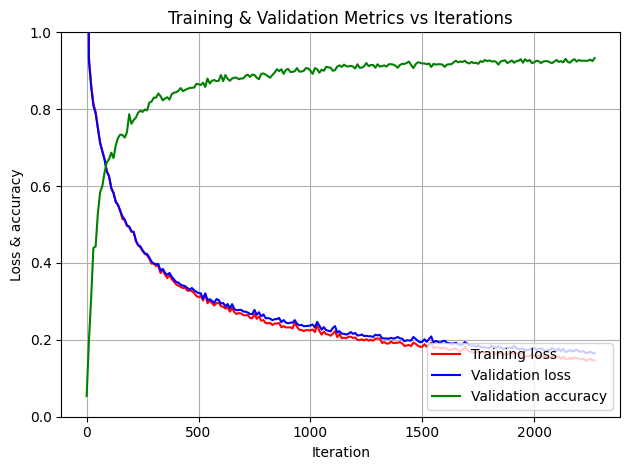

with a loss of 0.21817134336789407 and an accuracy 0.8915 on the test data


In [19]:
# Your code
model = DeepMLP([128, 128, 128, 64])
loss = MSE()
lr = 0.015
batch_size = 16
epochs = 4
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)
loss, accuracy = evaluate(model, loss, test_data, test_labels)
print(f"with a loss of {loss} and an accuracy {accuracy} on the test data")
# I have an accuracy of 90% with this model

## Part III. Going further

The following questions do not have a specific order, a limited number of bonus points can be granted on completing them.

**Q10.** Implement and test different non-linearities (Sigmoid, LeakyReLU, Tanh)

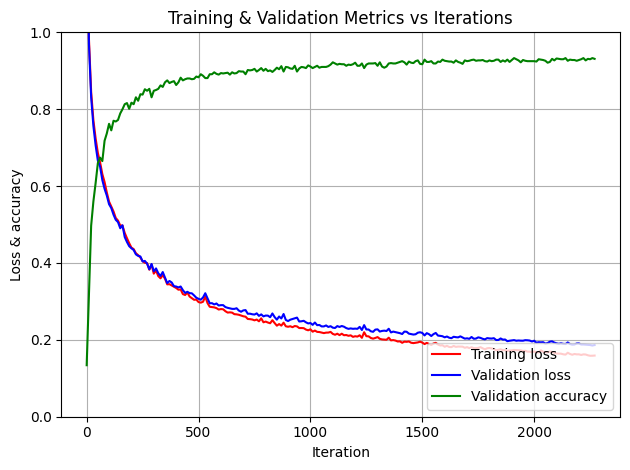

with a loss of 0.23759580645548908 and an accuracy 0.8935 on the test data with ReLU as non-linearity


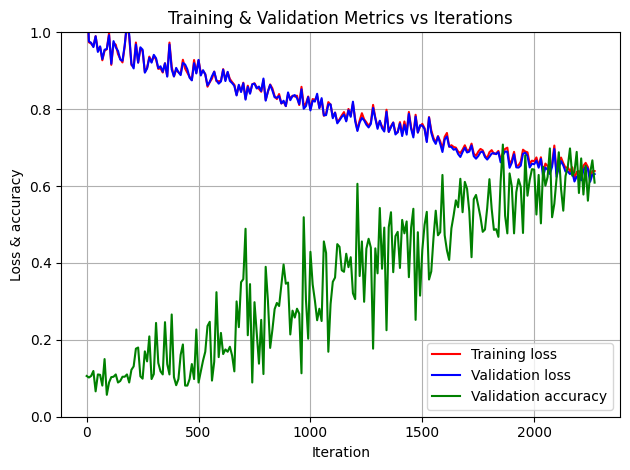

with a loss of 0.6683329981190604 and an accuracy 0.533 on the test data with Sigmoid as non-linearity


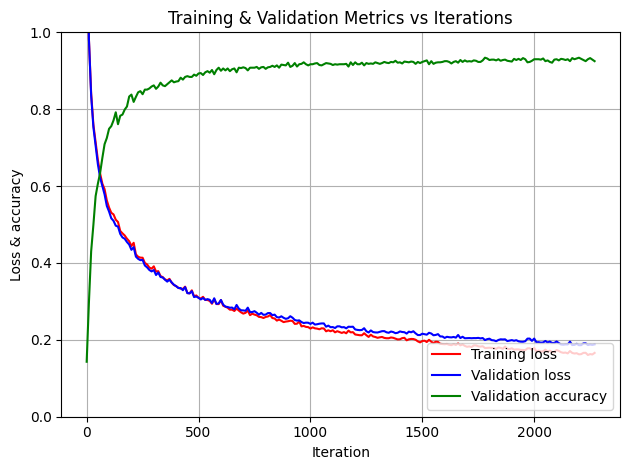

with a loss of 0.23426591196576174 and an accuracy 0.903 on the test data with LeakyReLU as non-linearity


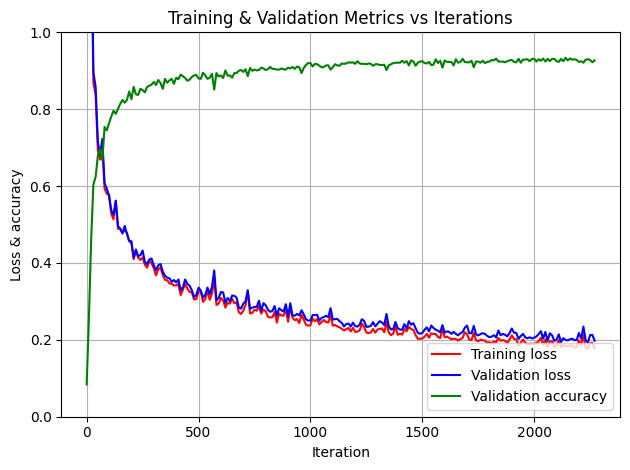

with a loss of 0.25237282277181167 and an accuracy 0.9045 on the test data with Tanh as non-linearity


In [28]:
# Your code
class Sigmoid(Module):
    def __init__(self, bias=True):
        super(Sigmoid, self).__init__()

    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = self.output * (1 - self.output) * gradOutput
        return self.gradInput

class LeakyReLU(Module):
    def __init__(self, bias=True):
        super(LeakyReLU, self).__init__()
        self.alpha = 0.01

    def forward(self, x):
        self.output = np.maximum(self.alpha * x, x)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.where(x > 0, 1, self.alpha) * gradOutput
        return self.gradInput

class Tanh(Module):
    def __init__(self, bias=True):
        super(Tanh, self).__init__()

    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = (1 - self.output**2) * gradOutput
        return self.gradInput


for non_linearity in [ReLU, Sigmoid, LeakyReLU, Tanh]:
    model = DeepMLP([128, 128, 128], non_linearity=non_linearity)
    loss = MSE()
    lr = 0.015
    batch_size = 16
    epochs = 4
    train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)
    loss, accuracy = evaluate(model, loss, test_data, test_labels)
    print(f"with a loss of {loss} and an accuracy {accuracy} on the test data with {non_linearity.__name__} as non-linearity")

    """
    In this case, with these params, LeakyReLU is best tied with ReLU, then comes Tanh, and finally Sigmoid that is substantialy worse.
    """

**Q11.** Implement and test different loss functions (L1, Cross-Entropy)

> Add blockquote



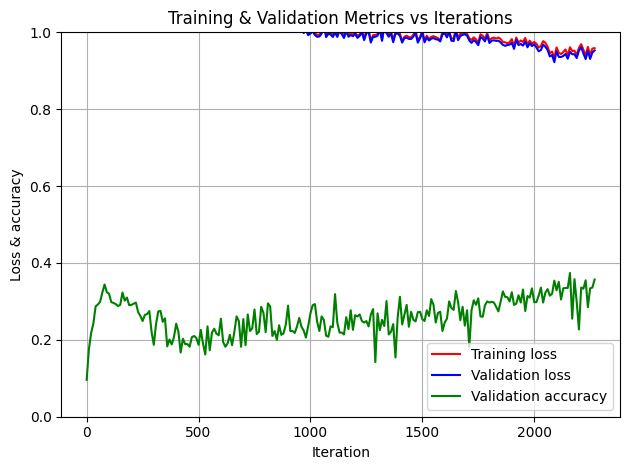

with a loss of 0.9685938186040023 and an accuracy 0.2795 on the test data with <__main__.L1 object at 0x7c5b29e3d250> as loss


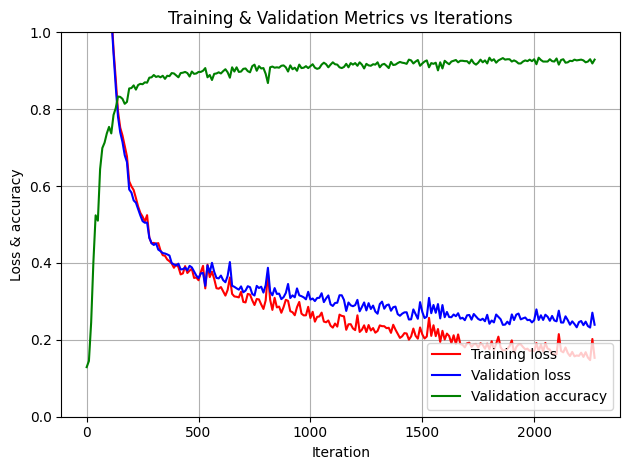

with a loss of 0.2891497644099428 and an accuracy 0.906 on the test data with <__main__.CrossEntropy object at 0x7c5b29e870b0> as loss


'\nHere we see that CrossEntropy works as well as MSE, and L1 doesnt seems to be working.\n'

In [27]:
# Your code
class L1(Module):
    def __init__(self, num_classes=10):
        super(L1, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, int(labels[i])] = 1
        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        per_sample = np.sum(np.abs(target - x), axis=1)
        self.output = per_sample
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = np.sign(x - target) / x.shape[0]
        return self.gradInput


class CrossEntropy(Module):
    def __init__(self, num_classes=10):
        super(CrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.probs = None

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, int(labels[i])] = 1
        return target

    def forward(self, x, labels):
        z = x - np.max(x, axis=1, keepdims=True)
        expz = np.exp(z)
        self.probs = expz / np.sum(expz, axis=1, keepdims=True)

        target = self.make_target(x, labels)
        per_sample = -np.sum(target * np.log(self.probs + 1e-12), axis=1)
        self.output = per_sample
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = (self.probs - target) / x.shape[0]
        return self.gradInput

for loss in [L1(), CrossEntropy()]:
    model = DeepMLP([128, 128, 128])
    lr = 0.015
    batch_size = 16
    epochs = 4
    train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)
    loss_val, accuracy = evaluate(model, loss, test_data, test_labels)
    print(f"with a loss of {loss_val} and an accuracy {accuracy} on the test data with {loss} as loss")

"""
Here we see that CrossEntropy works as well as MSE, and L1 doesnt seems to be working.
"""

**Q12.** Add some momentum to your training procedure. How does it change the training behavior?

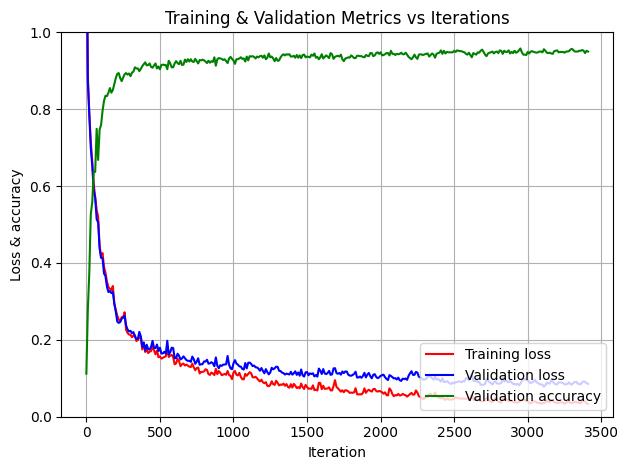

with a loss of 0.11112631671091805 and an accuracy 0.933 on the test data with linear-momentum


In [33]:
# Your code
class Linear_with_momentum(Module):
    """
    On ajoute ici une inertie à la descente de gradient
    """
    def __init__(self, in_features, out_features, bias=True, momentum=0.9):
        super(Linear_with_momentum, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.momentum = momentum

        std = math.sqrt(2/in_features)
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)

        self.v_weight = np.zeros_like(self.weight)
        self.v_bias = np.zeros_like(self.bias)


    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.T, x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr):
        self.v_weight = self.momentum * self.v_weight + self.gradWeight
        self.v_bias = self.momentum * self.v_bias + self.gradBias

        self.weight -= lr * self.v_weight
        self.bias -= lr * self.v_bias

model = DeepMLP([128, 128, 64, 32], linear = Linear_with_momentum)
loss = MSE()
lr = 0.015
batch_size = 16
epochs = 6
train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)
loss_val, accuracy = evaluate(model, loss, test_data, test_labels)
print(f"with a loss of {loss_val} and an accuracy {accuracy} on the test data with linear-momentum")
# with a loss of 0.125870183626063 and an accuracy 0.9245 on the test data with linear-momentum

# On voit donc malgré toutes ces diverses implémentations, que ça ne change pas grand chose au résultat final. ReLU() avec la classe lineaire de base sont déjà très bons pour ce problème.